# Lesson - Fuzzy Language in Business

The use of vague/fuzzy language is common in businesses. Oftentimes, people who work with us will use natural language to convey ideas that superficially look good, but when we inspect them more closely, we realize they are ill-defined.

Bad communication can have crippling effects on workflow. Being able to effectively communicate is crucial on several fronts:

- It facilitates the flow of information. This compounds as the number of people working on a project grows.
- It helps decision-makers act.
- It removes misunderstandings, creates clarity, and and motivates and unifies the participating teams.
- It aids in preparing people to accept change.
 - It often happens that low-level employees have long-established work habits that are required to change based on data-driven recommendations. Many times they are resistant to the change because they do not have enough context to understand why it is better that things change.
- It helps the manager coordinate with other managers and teams, so we can focus on the technical work.
- All of this culminates in us making a greater impact in the organization.

**Right Questions to Ask**
Once we know the real reason behind the data analysis request, we will be better prepared to answer it. It's not uncommon for the answer to easily come from a recurring report or from previous work, allowing us to answer to the request almost instantly.

Due to lack of analytical ability, lack of time, or just generally being out of touch with the organization's data ecosystem, the requests that fall on our lap may not be the best ways to tackle the underlying goal.

Once you know the reason behind the request, consider if the request is the right one. This often is not purely a data science task, but may also require domain knowledge (specific knowledge of the industry) or knowledge of operational constraints which we might not have (for example, it could be illegal to actively reach out to customers for surveying purposes). For these reasons, it is a good idea to brainstorm possible ways of reaching the goal with whoever makes the request and with people within the organization who may have a more holistic view of the business.

**Dealing with Fuzzy Language**

For various reasons, the use of nebulous language is part of the job:

- People may not have the technical expertise to be more precise — not uncommon for managers and colleagues in non-technical teams (project managers and operational teams for instance).
- People may not have the time to dig into the details — typical for management.
- It's not other people's job to give concrete definitions to inherently vague terms.

Moving from imprecise to precise language is something that we as data analysts/scientists need to do repeatedly.

### Business Scenario

You're working for the online department of Floormart and your manager asked you to identify "your" best customers. initially, you did not ask for the details. But you now realize you need more information from them, you reach out through the company's messaging app and clarified certain details about the best customers and the end goal the manager had in mind. Manager clarifies that it actually means Floormart's customers who have never purchased online (physical store customers). 
And as per your analysis, what is actually required is a list of the best physical store customers (name and address) to send online discount coupons to. You should use your best judgment to figure out what the value of the coupons should be. 
You musy also figure what criteria to use to determine who the "best" customers are. You also have to make sure you don't steal any of the physical store customers. 
Based on above, you conclude that you should send coupons to the best **churned customers.**

### Churned Customers

**Customer churn** is when a customer ceases to be a customer. 
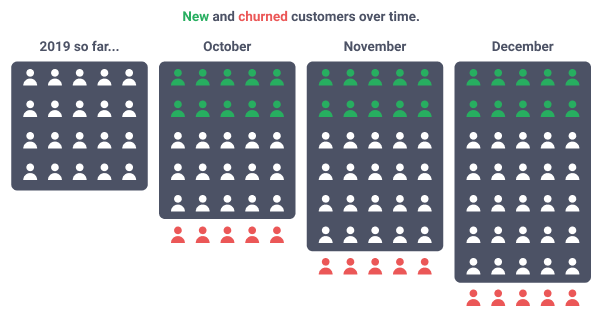

In the case of subscription-based businesses, customer churn happens when a customer unsubscribes. Otherwise, it's a little harder to define and we have to use `proxies`. In the above scenario, we use a proxy by defining a churned customer as "a customer who hasn't purchased anything for over three months."

We will now read and explore the dataset of customers in the shape of a text file `rfm_xmas19.txt`:
```
import pandas as pd

data = pd.read_csv("rfm_xmas19.txt", parse_dates=["trans_date"])
print(data.info())

```
We have used the option `parse_dates` with `pd.read_csv`. It allows us to immediately set the appropriate date type to the selected columns. [`pandas.read_csv()`'s documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)

In order to label churned customers, we will first find the latest purchase for each customer:

```
group_by_customer = data.groupby("customer_id")
last_transaction = group_by_customer["trans_date"].max()
last_transaction.sample(5)
```

**Exercise**
In this scenario, a churned customer is one who hasn't purchased anything since October 16 (three months).

- Begin by using `pd.DataFrame()` to have the data in `last_transaction` as a dataframe. Assign it to `best_churn`.
- Add a column called `churned` that should have the value of 1 if the customer has churned and 0 otherwise.
- Create a datetime object representing October 16, 2019. Assign it to `cutoff_day`.
- Use `best_churn["trans_date"].apply()` with an appropriate function to code the rationale in the instruction.

In [1]:
import pandas as pd
import datetime as dt

data = pd.read_csv("rfm_xmas19.txt", parse_dates=["trans_date"])
group_by_customer = data.groupby("customer_id")
last_transaction = group_by_customer["trans_date"].max()


best_churn = pd.DataFrame(last_transaction)

cutoff_day = dt.datetime(2019, 10, 16) # 3 months ago

best_churn['churned'] = best_churn["trans_date"].apply(lambda date:1 if date<cutoff_day else 0)

# Above lambda function represents fol logic
# def func(date):
#     if date < cutoff_day:
#        return 1
#     else:
#         return 0

print(best_churn.info())
print(best_churn.head(5))

<class 'pandas.core.frame.DataFrame'>
Index: 6889 entries, FM1112 to FM9000
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   trans_date  6889 non-null   datetime64[ns]
 1   churned     6889 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 161.5+ KB
None
            trans_date  churned
customer_id                    
FM1112      2019-10-14        1
FM1113      2019-11-09        0
FM1114      2019-11-12        0
FM1115      2019-12-05        0
FM1116      2019-05-25        1


### Aggregate Data by Customer

We'll now focus on finding the best customers. This is a two-part problem: Find a ranking mechanism. Determine a threshold to identify the best customers.

We will use a very simple weighted sum model to classify customers. It as a scoring model that assigns a number to each customer that represents how good a customer they are. We take two criteria into account: Amount spent and number of purchases made, and that the scores should be the same weight. This means that a customer who spent a lot is worth as much as someone who made many purchases.

**"(0.5 x number of purchases) + (0.5 x amount spent)"**

 if a customer has made two purchases totalling $500, their score would be
 **(0.5 x 2) + (0.5 x 500)**
 which results in a score of **251** 

**Exercise**

- Use the groupby object `group_by_customer` to get the number of purchases by each customer as `nr_of_transactions` as a column in `best_churn`  
Use `group_by_customer` together with an appropriate aggregating method to get the total amount spent by each customer as a column in `best_churn` called `amount_spent`.
- Drop the `trans_date` column.

In [3]:
best_churn["nr_of_transactions"] = group_by_customer.size() # or group_by_customer.count()
print(best_churn.head(5))


            trans_date  churned  nr_of_transactions
customer_id                                        
FM1112      2019-10-14        1                  15
FM1113      2019-11-09        0                  20
FM1114      2019-11-12        0                  19
FM1115      2019-12-05        0                  22
FM1116      2019-05-25        1                  13


In [4]:
best_churn["amount_spent"] = group_by_customer["tran_amount"].sum()
best_churn.drop("trans_date", axis=1, inplace=True)
print(best_churn.head(5))

             churned  nr_of_transactions  amount_spent
customer_id                                           
FM1112             1                  15          1012
FM1113             0                  20          1490
FM1114             0                  19          1432
FM1115             0                  22          1659
FM1116             1                  13           857


### Ranking Customers: Min-Max Scaling
The formula of weighted sum, that we described above for ranking customers, is very skewed as:
- Money spent is usually much higher than the number of transactions;
- We are using the same weight (0.5)  for both criteria;

We'll fix this by appropriately modifying the data. We'll use a technique called min-max feature scaling. The goal of this technique is to compare different scales in a meaningful way.

the ranges of `nr_of_transactions` and `amount_spent` are.
```
best_churn[
    ["nr_of_transactions", "amount_spent"]
].describe().loc[["min", "max"]]

```

nr_of_transactions	amount_spent
            min	4.0	    149.0
            max	39.0	2933.0
            
`nr_of_transactions` ranges between 4 and 39, while `amount_spent` ranges between 149 and 2933.

Here's what the distributions look like (seen together):
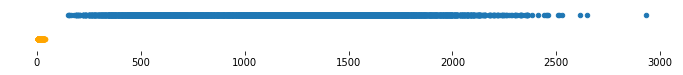


Notice how minuscule the number of transactions is relative to the amount spent. The min-max scaling technique will rescale both columns so that we can make an apples-to-apples comparison.

Mathematically; **{X-min(X)}\{max(X)-min(X)}**; where X represents the column we want to scale.

**Exercise**

Use the methods `pandas.Series.min()` and `pandas.Series.max()` together with the formula above to:
- Create a column named `scaled_tran` (in the `best_churn` dataframe) that scales `nr_of_transactions`.
- Create a column named `scaled_amount` in the `best_churn` dataframe that scales `amount_spent`.
- Create a column called `score` using the weighted sum formula described earlier. Make sure you use the scaled columns created in the previous instruction.
- Multiply `score` by `100` to make it more readable. Assign back to the `score` column in `best_churn`.
Use the method `pandas.DataFrame.sort_values()` to sort best_churn by `score`.
- Either use the `inplace` argument or assign back to `best_churn`.
- Sort it in descending order.

In [5]:
best_churn["scaled_tran"] = (best_churn["nr_of_transactions"] - best_churn["nr_of_transactions"].min())/(best_churn["nr_of_transactions"].max() - best_churn["nr_of_transactions"].min())

best_churn["scaled_amount"] = (best_churn["amount_spent"] - best_churn["amount_spent"].min())/(best_churn["amount_spent"].max() - best_churn["amount_spent"].min())

best_churn["score"] = (0.5*best_churn["scaled_tran"]) + (0.5*best_churn["scaled_amount"])

best_churn["score"] = best_churn["score"]*100

best_churn.sort_values("score", inplace=True, ascending=False)

print(best_churn.head(5))

             churned  nr_of_transactions  amount_spent  scaled_tran  \
customer_id                                                           
FM4424             0                  39          2933     1.000000   
FM4320             1                  38          2647     0.971429   
FM3799             1                  36          2513     0.914286   
FM5109             0                  35          2506     0.885714   
FM3805             1                  35          2453     0.885714   

             scaled_amount       score  
customer_id                             
FM4424            1.000000  100.000000  
FM4320            0.897270   93.434934  
FM3799            0.849138   88.171182  
FM5109            0.846624   86.616892  
FM3805            0.827586   85.665025  


### Determining a Threshhold 

We need to decide on a threshold to determine which customers are "the best." some factors that we decided to take into account:

- The budget is $1,000.
- No indication was given about how much each coupon would be worth — it's for us to decide.
- The coupons need to be good enough to prompt people to actually use them.
They can't be too high because:
- That reduces the number of customers who get them.
- It would be like giving away money.
- Due to price dumping, it could be illegal.
From our experience, we know that a 30% discount is already very enticing;

We decide to employ the following strategy to determine the cutoff point:

- Find the mean of the transactions and compute 30% of that. Make this the value of the coupon;
- Divide the budget by the value obtained above to get the number of coupons you're going to be sending out;
- Pick the first n churned customers where n is the result of the calculation done in the previous step.


**Exercise**

- Use the `data` dataframe to compute the mean transaction, find 30% of this value and assign the result to `coupon`.
- Divide the budget by coupon. Assign it to `nr_of_customers`.

In [6]:
coupon = 0.3*data["tran_amount"].mean()
nr_of_customers = 1000/coupon

print(coupon, nr_of_customers)

19.4975736 51.28843314123969


### Delivering the Results

From results above, we round `coupon` value to $20, and then decide to send the coupon to the top 50 churned customers.

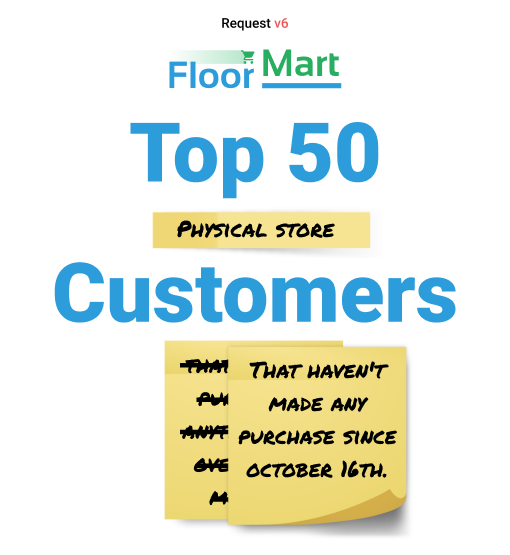

After we're done with the final step (pick the first 50 churned customers), we'll have the required information in a pandas dataframe. This isn't a transmittable interface. Typically, this sort of data is sent as text files.

To save a dataframe as a text file, we can use the [`pandas.DataFrame.to_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) method.

**Exercise**

Create a dataframe with the top 50 churned customers
- Filter best_churn for only the churned customers.
- Retrieve the first 50 rows of the resulting filter.
- Assign the result to `top_50_churned`.
Use the `pandas.DataFrame.to_csv()` method to save `top_50_churned` into a text file named `best_customers.txt`.

In [10]:
top_50_churned = best_churn[best_churn["churned"] == 1][:50]

print(top_50_churned)

top_50_churned.to_csv("best_customers.txt")

             churned  nr_of_transactions  amount_spent  scaled_tran  \
customer_id                                                           
FM4320             1                  38          2647     0.971429   
FM3799             1                  36          2513     0.914286   
FM3805             1                  35          2453     0.885714   
FM5752             1                  33          2612     0.828571   
FM4074             1                  34          2462     0.857143   
FM1215             1                  35          2362     0.885714   
FM2620             1                  35          2360     0.885714   
FM1580             1                  33          2329     0.828571   
FM2951             1                  32          2382     0.800000   
FM3163             1                  31          2413     0.771429   
FM5868             1                  31          2260     0.771429   
FM1695             1                  32          2174     0.800000   
FM1865